Первое практическое занятие мы начнем с реализации dynamic time warping (DTW) алгоритм на основе token passing algorithm (TPA).

У нас имеется несколько эталонов (различные вариации произнесения слов YES и NO) и пару записей (так же YES и NO). С помощью алгоритма DTW нам будет необходимо определить на какой из эталонов больше всего похожа каждая запись. Данные wav файлы взяты из открытой базы данных Google Speech Commands Dataset (https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html).

# Практика №1

### Bootstrap

In [2]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
# загрузка данных, необходимых для работы
file_id = '1VNi62ZxZA7rgMKsvECDGZdl3WQJcBKRb' # URL id. 
file_name = 'lab1.zip'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(file_name)

In [4]:
!unzip -q lab1.zip
!rm -rf lab1.zip sample_data
%cd lab1

/content/lab1


In [74]:
import os
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
 
 
 
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Рассмотрим на примере один из эталонов:

In [6]:
wav_example = 'data/yes_no/etalons/yes_004ae714_nohash_0.wav'
 
# чтение wav файла:
x, sr = librosa.load(wav_example, sr=None)     # sr=None to preserve the native sampling rate
 
print('Number of samples: {}'.format(len(x)))
print('Sampling rate: {} Hz'.format(sr))
print('Duration: {:.2f} s'.format(len(x)/sr))  # ~ librosa.get_duration(x, sr)
 
# воспроизведение:
ipd.Audio(x, rate=sr)

Number of samples: 16000
Sampling rate: 16000 Hz
Duration: 1.00 s


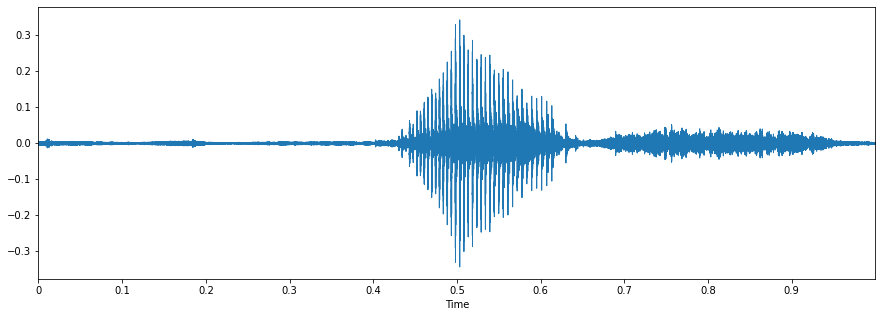

In [7]:
# Временное представление сигнала:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
librosa.display.waveplot(x, sr=sr)

Text(0.5, 1.0, 'Log-frequency power spectrogram')

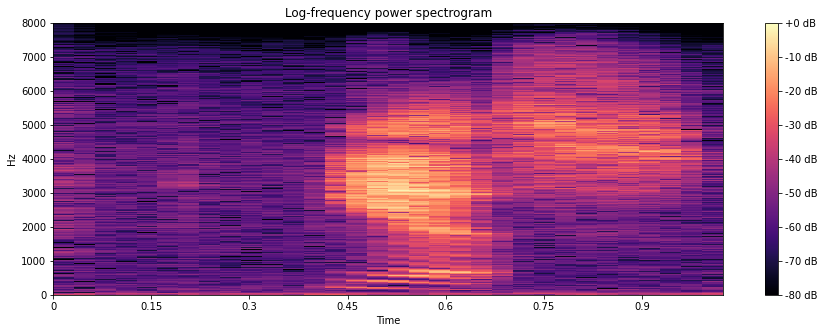

In [8]:
# спектрограмма:
D = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max)
librosa.display.specshow(D, sr=sr, y_axis='hz', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

Теперь посчитаем речевые признаки нашего эталона.
Для начала будем работать с 13-ти размерными MFCC признаками.

In [9]:
# n_fft = 25 ms        -- длина кадра
# hop_length = 10 ms   -- длина шага
# тогда в отчетах получаем следующее:
n_fft = int(sr * 0.025)
hop_length = int(sr * 0.01)
 
 
mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)
print(mfcc.shape)
print(mfcc[:, 0]) # вектор признаков нулевого кадра

(13, 101)
[-668.8059      -1.2019875    4.53354     35.322647     9.764597
    9.849829    10.895137    15.9373       4.3746996   11.116629
    4.147642     1.4780188   -5.5366154]


Теперь приступим к описанию самого DTW алгоритма.
Для начала нам потребуется создать граф, ветвями которого будут наши эталоны, с которыми мы и будем сравнивать записи. Все ветви графа будут состоят из узлов типа State. Каждый такой узел представляет собой описание отдельного кадра эталона. Т.е. число узлов в ветви равно числу кадров в эталоне.

На данном этапе узлы в графе будут иметь переходы только в себя и следующий узел. Нулевой узел является корневым и имеет переходы в начальные узлы каждой ветви. Финальный узел каждой ветви имеет переход только в себя. Схема такого графа представлена ниже:

![](https://drive.google.com/uc?export=view&id=1PQwZSf9EFEZUWQt9dmOifpyqCM6uuCRM)

здесь мы имеем два эталона слов YES и NO длиной 4 и 3 кадра соответственно.

In [104]:
class State:
    def __init__(self, feats, index):  
        self.feats = feats            # вектор признаков узла
        self.is_final = False         # является ли этот узел финальным в слове
        self.word = None              # слово эталона (назначается только для финального узла)
        self.best_token = None        # лучший токен (по минимуму дистанции) в узле
        self.current_word = None      # текущее слово эталона
        self.next_states = []         # список следующих узлов
        self.index = index            # индекс узла 
 
        
def load_graph(etalons_dict):
    start_state = State(None, 0)
    graph = [start_state, ]
    state_index = 1
    for word in etalons_dict.keys():
        # print(word)
        previous_state = start_state
        state_one_step = None
        state_two_step = None
        step = 0
        for feats_frame in etalons_dict[word]:
            # print(feats_frame)
            state = State(feats_frame, state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # добавление перехода в себя
            previous_state.next_states.append(state)

            #-----------------------------TODO №2-----------------------------------
            # Добавьте переходы через один и через два узла
            # (hint): добавлять переходы проще задним числом
            #-----------------------------------------------------------------------
            if step == 0:
              state_one_step = state

            if step == 2:
              state_one_step.next_states.append(state)
              state_two_step = state_one_step
              state_one_step = previous_state

            if step >= 3:
               state_one_step.next_states.append(state)             
               state_two_step.next_states.append(state)
               state_two_step = state_one_step
               state_one_step = previous_state               
            
            step += 1
            
            
            previous_state = state
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph
 
 
def print_graph(graph):
    if not os.path.exists('exp'):
        os.mkdir('exp')
    with open('exp/graph.txt', 'w') as fn:
        np.set_printoptions(formatter={'float': '{: 0.1f}'.format})
        for state in graph:
            next_state_indexes = [s.index for s in state.next_states]
            fn.write("State: index={} word={} is_final={} next_state_indexes={} ftr={} \n".format(
                state.index, state.word, state.is_final, next_state_indexes, state.feats))
    print("*** See exp/graph.txt ***")

Подготовка наших эталонов и записей для распознавания:

In [ ]:
# etalons_dict - mfcc от аудио:
# название файла: mfcc

# graph is a list of states

In [11]:
def load_data_dict(dir_path):
    data_dict = {}
    for wav_name in os.listdir(dir_path):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        data_dict[wav_name] = mfcc.T
    
    return data_dict

In [12]:
etalons_dir = "data/yes_no/etalons"
records_dir = "data/yes_no/records"
 
etalons_data_dict = load_data_dict(etalons_dir)
records_data_dict = load_data_dict(records_dir)

In [13]:
list(etalons_data_dict.keys())[0]

'yes_004ae714_nohash_0.wav'

In [14]:
list(etalons_data_dict.values() )[0]

array([[-6.6880591e+02, -1.2019875e+00,  4.5335398e+00, ...,
         4.1476421e+00,  1.4780188e+00, -5.5366154e+00],
       [-5.7303217e+02,  3.1695676e-01, -2.8165852e+01, ...,
         1.7501625e+01,  2.8345743e+01, -2.2546976e+01],
       [-6.2920520e+02,  1.5665743e+01, -1.5180624e+01, ...,
         1.2882612e+01,  2.1672092e+01, -1.2775855e+01],
       ...,
       [-6.6460303e+02,  9.0029736e+00,  5.7805023e+00, ...,
         9.3825407e+00,  5.7785254e+00, -7.3107214e+00],
       [-6.4602637e+02,  2.8180500e+01,  1.0146416e+01, ...,
        -1.7838681e-01,  1.4548928e+01, -1.6295463e+00],
       [-6.8609027e+02, -1.5301874e+00, -4.5991902e+00, ...,
        -8.8548946e-01,  1.5672644e+01,  4.6687841e+00]], dtype=float32)

In [15]:
list(etalons_data_dict.values() )[0].shape

(101, 13)

In [105]:
graph = load_graph(etalons_data_dict)
print_graph(graph)

*** See exp/graph.txt ***


Далее идет описание класса Token и самого алгоритма TPA:

- Алгоритм TPA двигается последовательно по кадрам записи и на каждом кадре берёт множество токенов от предыдущего кадра, и порождает множество токенов для текущего кадра.
- Один токен – это вещь, олицетворяющая собой один из возможных вариантов разметки (соотнесения кадров записи кадрам эталона), заканчивающаяся на данном кадре. По токену можно понять, какую суммарную дистанцию набрал данный токен (т.е. то, насколько он хорош), в каком узле графа эталонов он находится (чтобы от него можно было породить токен для следующего кадра), и на ветке какого слова он находится на данный момент.
- На некотором кадре всё множество токенов описывает все возможные разметки, которые можно получить к данному кадру. После обработки последнего кадра, мы просто переберём все финальные токены (разметки) и выберем лучший (та, которая имеет минимальное суммарное расстояние от записи до эталона).
- Финальные токены – это токены, которым соответствует законченная разметка (то есть та, в которой после финального кадра мы оказались в финальном узле графа). Остальные токены могу рассматриваться как бракованные.

Получается, что TPA (в том виде, в котором он тут описан) – это удобная форма записи полного перебора всех возможных разметок.

### Проблемы:
Такой TPA будет перебирать все возможные варианты разметки, что приведет к значительному увеличению времени работы нашего DTW. Для решения этой проблемы мы будем отбрасывать "плохие" токены еще на этапе прохождения по графу. Этим занимаются, так называемые, beam и state prunings.

### <b>state pruning</b>:
В классе State нужно добавить атрибут best_token – ссылку на лучший токен, находящийся в данном стейте на текущем кадре записи. После порождения всех токенов за один кадр записи, пройдемся по каждому из полученных next_tokens, затем впишем текущий токен в State.best_token (здесь State – это узел, на котором находится токен), убив предыдущий лучший токен, либо убьем сам токен, если он хуже лучшего на этом узле. За жизнеспособность токена отвечает его атрибут is_alive (True или False соответственно). Логика в том, что если несколько токенов находятся в узле n, то кратчайшее расстояние, которое им надо преодолеть до финиша одинаковое. Т.е. мы можем оставить только лучший из них, а остальные отсеять. Главное не забыть очистить поле best_token у всех узлов графа перед началом обработки следующего кадра записи.

### <b>beam pruning</b>:
Идея состоит в том, чтобы на каждом кадре записи находить плохие токены и откидывать их (token.is_alive = False). 
Плохие – это,очевидно, накопившие слишком большое отклонение от стейтов, по которым они идут. Слишком большое отклонение – это непонятно какое (может токен плохой, может слово слишком длинное, может звук очень плохой – не разобрать). Поэтому "качество" токена считают относительно лучшего токена. Заведем переменную threshold (обычно её называют beam – ширина луча поиска), и если token.dist > best_token.dist + threshold, то token плохой и мы его отбросим.
Выкидывая какой-то токен из-за его отклонения, мы рискуем тем, что через сколько-то кадров все потомки выживших токенов могут оказаться очень плохими, а только потомки отброшенного токена оказались бы чудо как хороши. То есть, вводя threshold, мы вводим ошибку. Поэтому threshold нужно подобрать так, чтобы скорость работы алгоритма сильно выросла, а ошибка выросла незначительно.

Введение этих методов может привести к тому, что у нас просто не окажется в конце выживших токенов в финальных узлах графа. Для того, чтобы иметь возможность выдавать результат в этом случае, мы введем дополнительный атрибут current_word у класса State. Теперь в любом узле каждой ветви будет храниться слово соответствующего эталона для этой ветви. 

Тогда в конце работы DTW, если у нас не будет живых финальных токенов, то мы просто выберем лучший из оставшихся и по полю state.current_word определим слово эталона.

In [17]:
def printToken(token):
     print("state.best_token=", token.state.best_token)
     print("dist=", token.dist)
     print("word=", token.word)
     print("alive=", token.alive)

In [111]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True        # является ли токен живым
 
 
def beam_pruning(next_tokens, beam_threshold):
    #--------------------------------TODO №1-----------------------------------
    # 1. Ищем токен с лучшей дистанцией из next_tokens
    # 2. Присваиваем token.aliv значение False, если дистанция этого токена больше, чем
    #    длина лучшего токена + beam_threshold
    #--------------------------------------------------------------------------
   
    distance = np.zeros(len(next_tokens))
    for i in range(len(next_tokens)):
      distance[i] = next_tokens[i].dist

    best_token_index = np.argmin(distance)
    thresh = distance[best_token_index] + beam_threshold
    idx = np.where(distance > thresh)[0]
    
    verbose = False 
    if verbose:
      print("next token distances = ", distance)
      print("best token distance = ", best_token_index) 
      print("thresh = ", thresh)    
      print("indexes of tokens to kill = ", idx)

    for i in idx:
       next_tokens[i].alive = False
    
    return next_tokens
 
 
def state_pruning(next_tokens):
    for token in next_tokens:  
        if not token.state.best_token:
            token.state.best_token = token
        else:
            if token.dist <= token.state.best_token.dist:
                token.state.best_token.alive = False
                token.state.best_token = token
            else:
                token.alive = False
                
    # сбрасываем best_token на None для всеx узлов графа:
    for token in next_tokens:                                                   
        if token.state.best_token:                     
            token.state.best_token = None              
    return next_tokens
 
 
def distance(X, Y):
    result = float(np.sqrt(sum(pow(X - Y, 2))))
    return result
 
 
def recognize(filename, features, graph, recognition_results, beam_threshold):
 
    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []

 
    for ftr_frame in tqdm(features, desc="recognition..."):#features are  mfcc, ftr_frame is a row of mfcc array
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)                 
                    new_token.dist += distance(ftr_frame, transition_state.feats)
                    next_tokens.append(new_token)
        
 
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)  
        #--------------------------------TODO №1-----------------------------------       
        next_tokens = beam_pruning(next_tokens, beam_threshold) 
        #--------------------------------------------------------------------------
        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)
 
    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word
 
    # вывод результата DTW
    print(f"result: {filename} ==> {win_token.state.word}")
 
    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word == record_word)
 
    return recognition_results

### Запустим наше распознавание

In [112]:
def run_recognizer(records_data_dict, graph, beam_threshold=10):
    start_time = time.time()
    recognition_results = []
 
    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename, records_data_dict[filename], 
                                        graph, recognition_results, beam_threshold)
 
    print("-" * 60)
    print(f"WER is: {(1 - sum(recognition_results)/len(recognition_results))*100:.2f}%")
    print(f"Total time is: {time.time() - start_time:.2f} sec")
    print("-" * 60)

    WER = (1 - sum(recognition_results)/len(recognition_results))*100
    t = time.time() - start_time
    return WER, t

In [116]:
run_recognizer(records_data_dict, graph, beam_threshold=160)


result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 2.04 sec
------------------------------------------------------------


(19.999999999999996, 2.042076826095581)

In [91]:
thresholds = np.arange(10, 320, 10)

WER = []
total_time = []

for thr in thresholds:
  w, t = run_recognizer(records_data_dict, graph, beam_threshold=thr)
  WER.append(w)
  total_time.append(t)


result: yes_39a12648_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_ff63ab0b_nohash_0.wav ==> no_0137b3f4_nohash_0.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> no_01d22d03_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_004ae714_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 50.00%
Total time is: 0.84 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_ff63ab0b_nohash_0.wav ==> no_0137b3f4_nohash_0.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> no_01d22d03_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_004ae714_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 50.00%
Total time is: 0.97 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_ff63ab0b_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> no_01d22d03_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_004ae714_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 50.00%
Total time is: 1.20 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_ff63ab0b_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> no_01d22d03_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> no_01d22d03_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_004ae714_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 60.00%
Total time is: 1.17 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_ff63ab0b_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> no_01d22d03_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_004ae714_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 50.00%
Total time is: 1.25 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> no_01d22d03_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_004ae714_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 40.00%
Total time is: 1.34 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> no_01d22d03_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_004ae714_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 30.00%
Total time is: 1.37 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_004ae714_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 1.49 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_004ae714_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 30.00%
Total time is: 1.44 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_004ae714_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 30.00%
Total time is: 1.43 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 1.67 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 1.63 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 1.75 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 1.86 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 1.87 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 1.92 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 2.10 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 2.21 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 2.03 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 2.08 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 30.00%
Total time is: 1.84 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 30.00%
Total time is: 2.05 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 30.00%
Total time is: 2.09 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 30.00%
Total time is: 2.05 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 30.00%
Total time is: 1.98 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 30.00%
Total time is: 2.09 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 30.00%
Total time is: 2.17 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 30.00%
Total time is: 2.15 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 30.00%
Total time is: 2.20 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 30.00%
Total time is: 2.53 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 30.00%
Total time is: 2.07 sec
------------------------------------------------------------


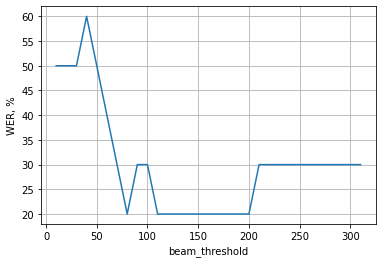

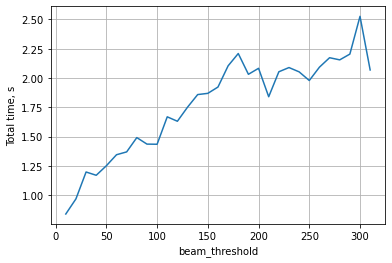

In [92]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(thresholds, WER)
plt.xlabel("beam_threshold")
plt.ylabel("WER, %")
plt.grid()


plt.figure()
plt.plot(thresholds, total_time)
# plt.axhline(y=16.63, color='r', linestyle='-')
plt.xlabel("beam_threshold")
plt.ylabel("Total time, s")
plt.grid()
plt.show()

In [88]:
thresholds

array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190, 210, 230, 250,
       270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490])

### <b>Задание №1</b>  (6 баллов):
Реализуйте функцию отсечения токенов <b>beam pruning</b>, описанную ранее. Подберие значение beam_threshold так, чтобы качество распознаваниия не ухудшалось. Во сколько раз ускорился процесс распознавания?

With state pruning only:

> WER is: 10.00%
> Total time is: 16.63 sec



    

With beam pruning:

```markdown
beam_threshold  | WER, % | Total time, s
----------------|--------|----------
 10             | 50     | 0.84
 60             | 40     | 1.03
 80             | 20     | 1.12

```

Optimal beam threshold = 80. Total time 1.12 s.

In [97]:
print("Процесс распознавания ускорился в ")
print(16.63 / 1.12)

Процесс распознавания ускорился в 
14.848214285714283


### <b>Задание №2</b> (4 балла):
На данный момент граф реализован так, что эталоны могут только растягиваться относительно записей. Но порой нужно уметь и сжиматься. Для этого нужно добавить для узлов графа дополнительные переходы через один и два состояния (нулевой узел должен остаться прежним).

Улучшила ли эта модификация качество распознавания?



*   Для варианта без beam pruning WER упала до 0
*   Для варианта с beam pruning и порога 80 не улучшила: качество было 20%, стало 30% (локальный минимум пропал). Однако для более высоких порогов произошло улучшение.


In [117]:
thresholds = np.arange(10, 320, 10)

WER2 = []
total_time2 = []

for thr in thresholds:
  w, t = run_recognizer(records_data_dict, graph, beam_threshold=thr)
  WER2.append(w)
  total_time2.append(t)


result: yes_39a12648_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> no_01d22d03_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_004ae714_nohash_0.wav



result: yes_39a6b995_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 40.00%
Total time is: 1.05 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_ff63ab0b_nohash_0.wav ==> no_0137b3f4_nohash_0.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> no_01d22d03_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 50.00%
Total time is: 1.30 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_ff63ab0b_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> no_01d22d03_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 50.00%
Total time is: 1.51 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_ff63ab0b_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> no_01d22d03_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 50.00%
Total time is: 1.58 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_ff63ab0b_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> no_01d22d03_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 50.00%
Total time is: 1.52 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_ff63ab0b_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 40.00%
Total time is: 1.80 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 40.00%
Total time is: 1.78 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 30.00%
Total time is: 1.92 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> no_019fa366_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 30.00%
Total time is: 2.04 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 2.20 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 2.24 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 2.47 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 2.51 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 2.54 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 3.01 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 2.85 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 2.85 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 3.02 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 3.17 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 3.16 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 3.30 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 3.43 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 3.47 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 3.66 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 3.79 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 3.73 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 3.98 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 4.03 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 4.08 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 4.20 sec
------------------------------------------------------------



result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



result: no_49af4432_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav
------------------------------------------------------------
WER is: 20.00%
Total time is: 4.31 sec
------------------------------------------------------------


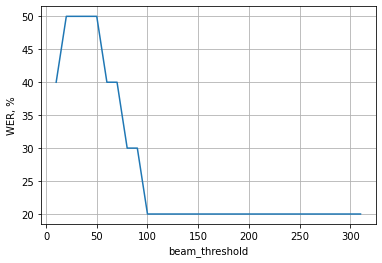

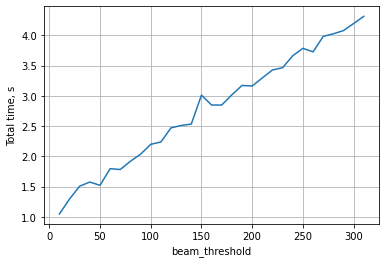

In [119]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(thresholds, WER2)
plt.xlabel("beam_threshold")
plt.ylabel("WER, %")
plt.grid()


plt.figure()
plt.plot(thresholds, total_time2)
# plt.axhline(y=16.63, color='r', linestyle='-')
plt.xlabel("beam_threshold")
plt.ylabel("Total time, s")
plt.grid()
plt.show()

In [ ]:
import numpy

In [ ]:
!OMP_NUM_THREADS

/bin/bash: OMP_NUM_THREADS: command not found
